In [1]:
%matplotlib inline
import tensorflow as tf
import os
import skimage.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_folder="/Users/kanhua/Dropbox/Programming/lyft-challenge/data"
test_file=os.path.join(data_folder,"CameraRGB/258.png")
test_file_label=os.path.join(data_folder,"CameraSeg/258.png")

In [3]:
test_image=skimage.io.imread(test_file)
test_label_image=skimage.io.imread(test_file_label)

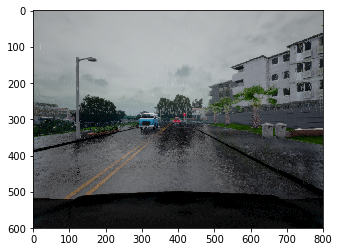

In [4]:
plt.imshow(test_image)

In [5]:
print(np.max(test_image))

239


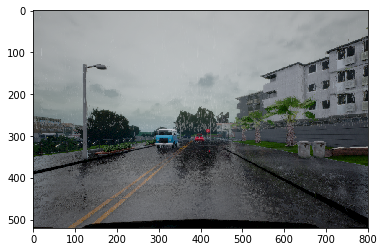

In [6]:
#cropping with numpy
y_max=520
plt.imshow(test_image[0:y_max,:])

In [7]:
image_pl=tf.placeholder(tf.uint8,[None,None,3])
cropped_image=tf.image.crop_to_bounding_box(image_pl,100,100,300,300)

In [8]:
with tf.Session() as sess:
    img=sess.run(cropped_image,feed_dict={image_pl:test_image})

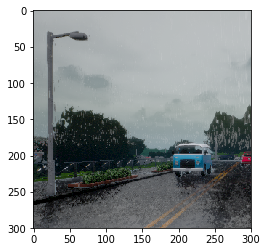

In [9]:
plt.imshow(img)

In [10]:
from inception_preprocessing import preprocess_for_train

0.8683333333333333


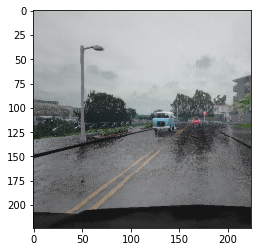

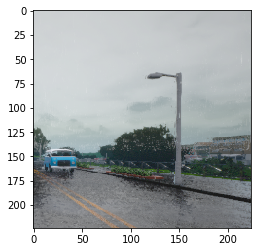

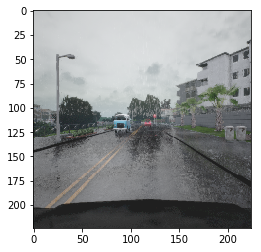

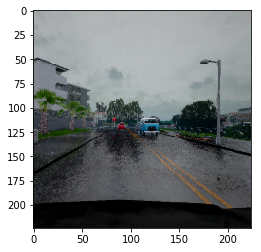

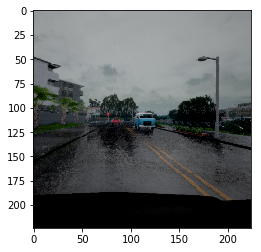

In [11]:
corner_h_ratio=521/600
print(corner_h_ratio)
incep_prop_graph=tf.Graph()
with incep_prop_graph.as_default() as df:
    image_pl=tf.placeholder(tf.uint8,[None,None,3])
    bbox=tf.constant([[[0.2,0.2,]]])
    ip_train_image=preprocess_for_train(image_pl,224,224,bbox=[[[0.0,0.0,0.1,0.1]]])
with tf.Session(graph=incep_prop_graph) as sess:
    train_writer=tf.summary.FileWriter("./log/crop",sess.graph)
    merged=tf.summary.merge_all()
    for i in range(5):
        img,summary=sess.run([ip_train_image,merged],feed_dict={image_pl:test_image})
        plt.figure()
        plt.imshow((img+1)/2)
        train_writer.add_summary(summary,i)

## Combine label image to crop

In [12]:
merge_graph=tf.Graph()
with merge_graph.as_default():
    raw_image=tf.placeholder(tf.uint8,[None,None,3])
    raw_label=tf.placeholder(tf.uint8,[None,None,1])
    stacked_image_label=tf.concat((raw_image,raw_label),axis=2)
    cropped_image_label=stacked_image_label[0:500,0:500,:]
    cropped_image=cropped_image_label[:,:,0:3]
    cropped_label=cropped_image_label[:,:,3]
with tf.Session(graph=merge_graph) as sess:
    cropped_image_n,cropped_label_n=sess.run([cropped_image,cropped_label],
             feed_dict={raw_image:test_image,raw_label:np.expand_dims(test_label_image[:,:,0],2)})

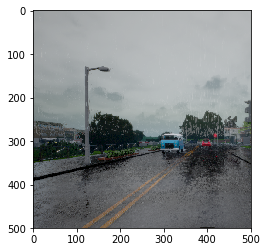

In [13]:
plt.imshow(cropped_image_n)

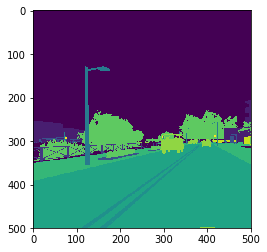

In [14]:
plt.imshow(cropped_label_n)

In [15]:
crop_graph=tf.Graph()
with crop_graph.as_default():
    #need to set up new variable scope here to reuse these variable names
    with tf.variable_scope("batch_crop"):
        raw_image=tf.placeholder(tf.uint8,[None,None,3])
        raw_label=tf.placeholder(tf.uint8,[None,None,1])
        stacked_image_label=tf.concat((raw_image,raw_label),axis=2)
        from inception_preprocessing import crop_image_label_for_train, random_distort_images
        cropped_image_label=crop_image_label_for_train(stacked_image_label,224,224,bbox=None)
        
        cropped_image=cropped_image_label[:,:,0:3]
        cropped_label=cropped_image_label[:,:,3:]
        color_distorted_image=random_distort_images(cropped_image)
with tf.Session(graph=crop_graph) as sess:
    train_writer=tf.summary.FileWriter("./log/crop",sess.graph)
    merged=tf.summary.merge_all()
    cropped_image_n,cropped_label_n,cropped_image_label_n,summary=sess.run([cropped_image,cropped_label,cropped_image_label,merged],
             feed_dict={raw_image:test_image,raw_label:np.expand_dims(test_label_image[:,:,0],2)})
    train_writer.add_summary(summary,0)

218


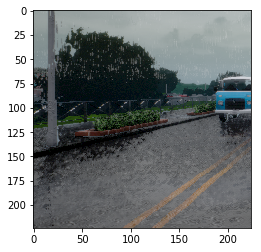

In [16]:
print(np.max(cropped_image_n))
plt.imshow(cropped_image_n)

In [19]:
print(cropped_label_n.shape)

(224, 224, 1)


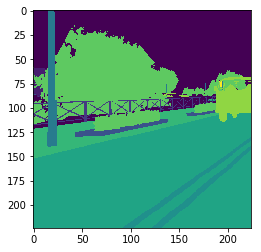

In [21]:
plt.imshow(cropped_label_n[:,:,0])